In [8]:
import dill
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.transforms as transforms
import numpy as np
import csv
from scipy import stats
import trompy as tp

# %run ..//JM_custom_figs.py
%matplotlib inline

In [9]:
# fig settings
scattersize=50
colors = ['darkturquoise','dodgerblue', 'darkblue']

In [10]:
datafolder = "C:\\Github\\Distraction-Paper\\data\\"
figfolder = "C:\\Github\\Distraction-Paper\\figs\\"
statsfolder = "C:\\Github\\Distraction-Paper\\stats\\"

try:
    pickle_in = open(datafolder + "distraction_data_only_snips.pickle", 'rb')
except FileNotFoundError:
        print('Cannot access pickled file')

[modDict, disDict, habDict] = dill.load(pickle_in)

In [11]:
# thph2.8 removed from analysis because no data on habituation day

modDict.pop('thph2.8')
disDict.pop('thph2.8')
;

''

In [12]:
# adds parameters used for figures - no. of distractors, distracted, not distracted and calculates probability of distraction

for day in [modDict, disDict, habDict]:
    rats = day.keys()
    for rat in rats:
        d = day[rat]
        # check that numbers add up
        d ['#ds'] =len(d['distractors'])
        d ['#distracted'] =len(d['distracted'])
        d ['#not-dis'] =len(d['notdistracted'])   
        if d['#not-dis'] + d['#distracted'] == d['#ds']:
            d['prob-distracted'] = d['#distracted'] / d['#ds']
        else:
            print("Something wrong in the number of distracted and non-distracted trials")


In [13]:
# makes lists with probability of distraction for each day

probdisMod, probdisDis, probdisHab = [], [], []
for day, output in zip([modDict, disDict, habDict],
                      [probdisMod, probdisDis, probdisHab]):
    rats = day.keys()
    for rat in rats:
        d = day[rat]
        output.append(d['prob-distracted'])

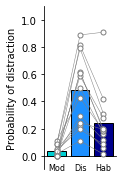

In [14]:
# makes panel for figure 1 showing probability of distraction

f, ax = plt.subplots(figsize=(2,3))
f.subplots_adjust(left=0.4)
tp.barscatter([probdisMod, probdisDis, probdisHab], paired=True,
           barfacecolor=colors, barfacecoloroption='individual',
           barlabels=['Mod', 'Dis', 'Hab'],
           barlabeloffset=-0.04,
           scattersize=scattersize,
           ax=ax)

ax.set_ylabel('Probability of distraction')
ax.set_xticks([])
# ax.set_xticks([1,2,3])
# ax.set_xticklabels(['Mod', 'Dis', 'Hab'])
ax.set_ylim([-0.1, 1.1])

f.savefig(figfolder+"fig1_probability of distraction.pdf")

In [15]:
# Stats for probability of distraction across days
def mean_and_sem(data):
    print(f"Mean: {np.mean(data)}, SEM: {np.std(data)/(np.sqrt(np.size(data)))}")

def bonferroni_corrected_ttest(data1, data2, comps=3, string_prefix=""):
    t, p = stats.ttest_rel(data1, data2)
    print(f"{string_prefix}t-stat: {np.abs(t):03.1f}, corrected p: {p*comps:03.4f}")

with open(statsfolder+'percent_distracted.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    for m, d, h in zip(probdisMod, probdisDis, probdisHab):
        writer.writerow([m, d, h])

# One-way ANOVA conducted in SPSS with this csv file

# these lines print mean and SEM for reporting and calculate Bonferroni posthocs
for data in [probdisMod, probdisDis, probdisHab]:
    mean_and_sem(data)
    
bonferroni_corrected_ttest(probdisMod, probdisDis, string_prefix="Mod vs. Dis - ")
bonferroni_corrected_ttest(probdisDis, probdisHab, string_prefix="Dis vs. Hab - ")
bonferroni_corrected_ttest(probdisMod, probdisHab, string_prefix="Mod vs. Hab - ")

Mean: 0.035736657778564794, SEM: 0.010063763058217283
Mean: 0.48438394306147653, SEM: 0.0686893248420231
Mean: 0.23832920617079603, SEM: 0.06087197101162473
Mod vs. Dis - t-stat: 6.4, corrected p: 0.0001
Dis vs. Hab - t-stat: 5.5, corrected p: 0.0004
Mod vs. Hab - t-stat: 3.4, corrected p: 0.0170


In [16]:
# function for rasters

def distractionrasterFig(ax, timelock, events,
                         pre = 1, post = 1,
                         sortevents=None, sortdirection='ascending',
                         title=''):

    if sortevents != None:
        if len(timelock) != len(sortevents):
            print('Length of sort events does not match timelock events; no sorting')

        if len(timelock) == (len(sortevents) + 1):
            sortevents.append(0)
            
            if sortdirection == 'ascending':
                sortOrder = np.argsort(sortevents)
            else:
                sortOrder = np.argsort(sortevents)[::-1]
                
            timelock = [timelock[i] for i in sortOrder]    
        else:
            if sortdirection == 'ascending':
                sortOrder = np.argsort(sortevents)
            else:
                sortOrder = np.argsort(sortevents)[::-1]
                
            timelock = [timelock[i] for i in sortOrder]
    
    rasterData = [[] for i in timelock]
    
    for i,x in enumerate(timelock):
        rasterData[i] = [j-x for j in events if (j > x-pre) & (j < x+post)]
 
    for ith, trial in enumerate(rasterData):

        xvals = [x for x in trial] 
        yvals = [1+ith] * len(xvals)
        
        pdplist = [lick for lick in xvals if lick > 0 and lick < 1]
        if len(pdplist) > 0:
            ax.scatter(xvals, yvals, marker='|', s=1, linewidths=0.5, color='k')
        else:
            ax.scatter(xvals, yvals, marker='|', s=1, color='xkcd:light blue')
    
    ax.set_title(title)

In [17]:
# makes scalebars for rasters and sets up axes

def scalebar4raster(ax, length=1, offset=1, ypos=0):
    
    # Turns off bottom axis and x ticks
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks([])
    
    # Gets x coordinates for scale bar
    xmin=ax.get_xlim()[0]
    x0=xmin+offset
    x1=xmin+offset+length
    
    # Sets up a transform for x in data coords and y in axis coords
    trans = transforms.blended_transform_factory(
    ax.transData, ax.transAxes)

    # Plots line using x and y and transform
    line = mpl.lines.Line2D([x0, x1], [ypos, ypos], lw=2., color='k', transform=trans)
    line.set_clip_on(False)
    ax.add_line(line)
    
    # Adds text below line
    ax.text((x1-length/2), ypos-0.02, '{} s'.format(length), va='top', ha='center', transform=trans)
    
    # Adds triangle to show distractor
    ax.plot(0, 1., marker="v", markersize=6, color='grey', clip_on=False, transform=trans)

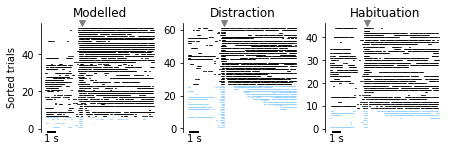

In [18]:
# makes raster plots for each day, change rat to see different rats and set savefig to True to save

rat='thph1.4'
savefig=True

f, ax = plt.subplots(ncols=3, figsize=(7,2))
f.subplots_adjust(left=0.1)

d=modDict[rat]
rasterPlot = distractionrasterFig(ax[0],
                                  d['distractors'],
                                  d['licks'],
                                  pre=5, post=10, sortevents=d['pdp'], sortdirection='dec',
                                  title='Modelled')

d=disDict[rat]
rasterPlot = distractionrasterFig(ax[1],
                                  d['distractors'],
                                  d['licks'],
                                  pre=5, post=10, sortevents=d['pdp'], sortdirection='dec',
                                  title='Distraction')

d=habDict[rat]
rasterPlot = distractionrasterFig(ax[2],
                                  d['distractors'],
                                  d['licks'],
                                  pre=5, post=10, sortevents=d['pdp'], sortdirection='dec',
                                  title='Habituation')

ax[0].set_ylabel('Sorted trials')

for axis in ax:
    #axis.set_xlabel('Time from distractor (s)')
    axis.spines['right'].set_visible(False)
    axis.spines['top'].set_visible(False)
    scalebar4raster(axis)

if savefig:
    f.savefig(figfolder+"fig1_raster plots.pdf")

In [19]:
# makes lists of PDPs (post-distraction pause) - can ccomment out a line to give raw PDPs rather than log PDPs

pdpsMod, pdpsDis, pdpsHab = [], [], []
pdpsMod_all, pdpsDis_all, pdpsHab_all = [], [], []
for day, output, output_all in zip([modDict, disDict, habDict],
                                  [pdpsMod, pdpsDis, pdpsHab],
                                  [pdpsMod_all, pdpsDis_all, pdpsHab_all]):
    rats = day.keys()
    for rat in rats:
        d = day[rat]
        
        # raw PDPs
        pdps = d['pdp']
        
        # log PDPs - comment out for raw PDPs
        pdps = np.log10(d['pdp'])
        
        
        output.append(np.mean(pdps))
        output_all.append(pdps)

(-0.9749821261009044, 1.486913129975438)


(-1.1, 1.5)

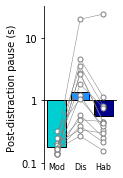

In [21]:
# plots panel for figure 1 showing PDPs

f, ax = plt.subplots(figsize=(2,3))
f.subplots_adjust(left=0.4)
tp.barscatter([pdpsMod, pdpsDis, pdpsHab], paired=True,
           barfacecolor=colors, barfacecoloroption='individual',
           barlabels=['Mod', 'Dis', 'Hab'],
           barlabeloffset=0.35,
           scattersize=scattersize,
#           barbaseline=-1.1,
           ax=ax)

ax.set_ylabel('Post-distraction pause (s)')
ax.set_xticks([])
print(ax.get_ylim())
# ax.spines['bottom'].set_visible(False)
# ax.plot(ax.get_xlim(), [-1.1, -1.1])

ax.set_yticks([-1, 0, 1, 2])
ax.set_yticklabels(['0.1', '1', '10', '100'])
ax.set_ylim([-1.1, 1.5])

# f.savefig(figfolder+"fig1_pdps.pdf")

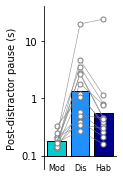

In [22]:
# plots panel for figure 1 showing PDPs - with baseline at 0

pdps_adj = []
for p_in in [pdpsMod, pdpsDis, pdpsHab]:
    p_out = [pdp +1 for pdp in p_in]
    pdps_adj.append(p_out)

f, ax = plt.subplots(figsize=(2,3))
f.subplots_adjust(left=0.4)
tp.barscatter(pdps_adj, paired=True,
           barfacecolor=colors, barfacecoloroption='individual',
           barlabels=['Mod', 'Dis', 'Hab'],
           barlabeloffset=-0.04,
           scattersize=scattersize,
#           barbaseline=-1.1,
           ax=ax)

ax.set_ylabel('Post-distractor pause (s)')
ax.set_xticks([])
# ax.spines['bottom'].set_visible(False)
# ax.plot(ax.get_xlim(), [-1.1, -1.1])

ax.set_yticks([0, 1, 2, 3])
ax.set_yticklabels(['0.1', '1', '10', '100'])
ax.set_ylim([-0.24, 2.6])

f.savefig(figfolder+"fig1_pdps_adjBL.pdf")

In [23]:
# stats for PDPs - ANOVA conducted in SPSS with .csv file

with open(statsfolder+'log_pdp.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    for m, d, h in zip(pdpsMod, pdpsDis, pdpsHab):
        writer.writerow([m, d, h])
        
# One-way ANOVA conducted in SPSS with this csv file

# these lines print mean and SEM for reporting and calculate Bonferroni posthocs
for data in [pdpsMod, pdpsDis, pdpsHab]:
    mean_and_sem(data)
    
bonferroni_corrected_ttest(pdpsMod, pdpsDis, string_prefix="Mod vs. Dis - ")
bonferroni_corrected_ttest(pdpsDis, pdpsHab, string_prefix="Dis vs. Hab - ")
bonferroni_corrected_ttest(pdpsMod, pdpsHab, string_prefix="Mod vs. Hab - ")

Mean: -0.7467827540034992, SEM: 0.030228347249829764
Mean: 0.13144915966881537, SEM: 0.1435405525481379
Mean: -0.2538688896811673, SEM: 0.14487316625592184
Mod vs. Dis - t-stat: 5.8, corrected p: 0.0002
Dis vs. Hab - t-stat: 4.9, corrected p: 0.0010
Mod vs. Hab - t-stat: 3.3, corrected p: 0.0177


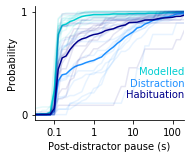

In [24]:
# plots panel with cumulative PDPs for Fig 1

def plot_cumulative_pdps(ax, pdps, bins, plot_all_data=True, color='k'):
    
    cumulative_sum = []
    for data in pdps:
        binned_data, _ = np.histogram(data, bins=bins, density=True)
        binned_data = np.divide(binned_data, 10) # divides to get probability from 0 to 1 (because bins are only 0.1s)
        cumsum_data = np.cumsum(binned_data)
        cumulative_sum.append(cumsum_data)
        if plot_all_data:
            ax.plot(bins[:-1], cumsum_data, color=color, alpha=0.1)
            
    ax.plot(bins[:-1], np.mean(cumulative_sum, axis=0), color=color)
    
#     shadedError(ax, cumulative_sum, linecolor=color)

    ax.set_xlim([-1.5, 2.3])
    ax.set_xticks([-1, 0, 1, 2])
    ax.set_xticklabels(['0.1', '1', '10', '100'])
    ax.set_xlabel('Post-distractor pause (s)')
    
    ax.set_ylabel('Probability')
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['0', '1'])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
        

colors = ['darkturquoise','dodgerblue', 'darkblue'] 
bins = np.arange(-2.1, 3.1, 0.1)

f, ax = plt.subplots(figsize=(2.6, 2.1))
f.subplots_adjust(left=0.15, bottom=0.2, right=0.95, top=0.95)

plot_cumulative_pdps(ax, pdpsMod_all, bins, color=colors[0])
plot_cumulative_pdps(ax, pdpsDis_all, bins, color=colors[1])
plot_cumulative_pdps(ax, pdpsHab_all, bins, color=colors[2])

ax.text(1, 0.4, 'Modelled', transform=ax.transAxes, ha='right', color=colors[0])
ax.text(1, 0.3, 'Distraction', transform=ax.transAxes, ha='right', color=colors[1])
ax.text(1, 0.2, 'Habituation', transform=ax.transAxes, ha='right', color=colors[2])
        
f.savefig(figfolder+"fig1_cumulative_pdps.pdf")
